## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping the data folder

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/smai_a4/fashion_mnist.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

!rm -rf /content/__MACOSX

## Solving Fragmentation issue for memory

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

## Imports

In [ ]:
import struct
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn

## Data loader

In [ ]:
class MultiMNISTDataset:
    def __init__(self, data, labels, batch_size=32, shuffle=True, task="classification"):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))  # Track the indexes for shuffling
        self.current_index = 0
        self.task = task

        if self.shuffle:
            self._shuffle_data()

    def _shuffle_data(self):
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __iter__(self):
        self.current_index = 0
        if self.shuffle:
            self._shuffle_data()
        return self

    def __next__(self):
        if self.current_index >= len(self.data):
            raise StopIteration

        # Compute the indices of the current batch
        start_idx = self.current_index
        end_idx = min(start_idx + self.batch_size, len(self.data))

        # Fetch the batch data and labels
        batch_indexes = self.indexes[start_idx:end_idx]
        batch_data = self.data[batch_indexes]
        batch_labels = self.labels[batch_indexes]

        # Update the current index
        self.current_index = end_idx

        # Convert NumPy arrays to PyTorch tensors
        batch_data_tensor = torch.from_numpy(batch_data).float()
        if self.task == "classification":
            batch_labels_tensor = torch.from_numpy(batch_labels).long()
        elif self.task == "regression":
            batch_labels_tensor = torch.from_numpy(batch_labels).float()

        return batch_data_tensor, batch_labels_tensor

## MLP Autoencoder Class

In [ ]:
class MLP_Autoencoder(nn.Module):
    def __init__(self, act_func: str, lr: float, dropout: float, optimiser: str):
        super(MLP_Autoencoder, self).__init__()

        self.loss = nn.MSELoss()

        if act_func == 'relu':
            self.activation = torch.relu
        elif act_func == 'sigmoid':
            self.activation = torch.sigmoid
        elif act_func == 'tanh':
            self.activation = torch.tanh
        else:
            raise ValueError('Activation function not supported.')

        self.lr = lr
        self.dropout = dropout
        self.op = optimiser

        # Encoder Layers
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)

        # Decoder Layers
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 512)
        self.fc7 = nn.Linear(512, 1024)
        self.fc8 = nn.Linear(1024, 28 * 28)

        self.normalise = nn.Sigmoid()

    def encoder(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

    def decoder(self, x):
        x = self.activation(self.fc5(x))
        x = self.activation(self.fc6(x))
        x = self.activation(self.fc7(x))
        x = self.fc8(x)
        x = self.normalise(x)
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def train_model(self, x, y, val_x, val_y, epochs, batch_size=32, weight_decay=1e-5):
        self.batch_size = batch_size
        torch.cuda.empty_cache()
        if self.op == 'adam':
            self.optimiser = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=weight_decay)
        elif self.op == 'sgd':
            self.optimiser = torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=weight_decay)
        else:
            raise ValueError('Optimiser not supported.')

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_dataloader = MultiMNISTDataset(x, y, batch_size=batch_size, task="regression")
        val_dataloader = MultiMNISTDataset(val_x, val_y, batch_size=batch_size, task="regression")

        train_loss_arr = list()
        val_loss_arr = list()

        train_iters = len(train_dataloader)
        val_iters = len(val_dataloader)

        for epoch in range(epochs):
            total_train_loss = 0
            total_val_loss = 0

            # Switching model to training mode
            self.train()

            for i, (images, labels) in enumerate(train_dataloader):
                train_images = images.to(device)
                train_labels = labels.to(device)

                # Forward Pass
                train_outputs = self.forward(train_images)
                train_loss = self.loss(train_outputs, train_labels)
                total_train_loss += train_loss.item()

                # Backward Pass
                self.optimiser.zero_grad()
                train_loss.backward()
                self.optimiser.step()
            avg_train_loss = total_train_loss / train_iters
            train_loss_arr.append(avg_train_loss)
            print(f'Epoch {epoch+1}/{epochs} done, Train Loss: {avg_train_loss}')

            # Switching model to evaluation mode
            self.eval()

            # Calculating validation loss
            with torch.no_grad():
                for i, (val_images, val_labels) in enumerate(val_dataloader):
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)
                    val_outputs = self.forward(val_images)
                    val_loss = self.loss(val_outputs, val_labels).item()
                    total_val_loss += val_loss
                avg_val_loss = total_val_loss / val_iters
                val_loss_arr.append(avg_val_loss)

        return train_loss_arr, val_loss_arr

    def get_latent_space(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, task="regression")
        encoded_reps = list()
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                outputs = self.encoder(images)
                encoded_reps.append(outputs.detach().cpu().numpy())
        encoded_reps = np.array(encoded_reps)
        return encoded_reps

    def reconstruction_error(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, task="regression")
        iters = len(dataloader)
        total_loss = 0
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.forward(images)
                total_loss += self.loss(outputs, labels).item()
        return total_loss / iters

## Function to read dataset

In [ ]:
def read_idx3_ubyte(filename):
    with open(filename, 'rb') as f:
        # Read the magic number and dimensions of the dataset
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))

        # Read the rest of the data
        images = np.frombuffer(f.read(), dtype=np.uint8)

        # Reshape to [num_images, rows, cols]
        images = images.reshape(num_images, rows, cols)

    return images

def read_idx1_ubyte(filename):
    with open(filename, 'rb') as f:
        # Read the magic number and number of items
        magic, num_items = struct.unpack('>II', f.read(8))

        # Read the label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return labels

## Reading and preprocessing data

In [ ]:
train_images = read_idx3_ubyte("/content/fashion_mnist/train-images-idx3-ubyte")
test_images = read_idx3_ubyte("/content/fashion_mnist/t10k-images-idx3-ubyte")
train_labels = read_idx1_ubyte("/content/fashion_mnist/train-labels-idx1-ubyte")
test_labels = read_idx1_ubyte("/content/fashion_mnist/t10k-labels-idx1-ubyte")

# Taking the first 50k images as train set and rest 10k images as val set
train_images, val_images = train_images[:50000], train_images[50000:60000]
train_labels, val_labels = train_labels[:50000], train_labels[50000:60000]

# Converting all the images to the range of [0, 1]
train_images, test_images, val_images = train_images / 255.0, test_images / 255.0, val_images / 255.0
print("Train, test and val data normalised.")

# Flattening the train, test and val images
flattened_train_imgs = list()
for img in train_images:
    flattened_train_imgs.append(img.flatten())
flattened_train_imgs = np.array(flattened_train_imgs)

flattened_test_imgs = list()
for img in test_images:
    flattened_test_imgs.append(img.flatten())
flattened_test_imgs = np.array(flattened_test_imgs)

flattened_val_imgs = list()
for img in val_images:
    flattened_val_imgs.append(img.flatten())
flattened_val_imgs = np.array(flattened_val_imgs)

print("Train, test and val images flattened.")

Train, test and val data normalised.
Train, test and val images flattened.


## Selecting device and epochs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 100

print("Device:", device)

Device: cuda


## Training MLP Autoencoder

Epoch 1/100 done, Train Loss: 0.09079543775232343
Epoch 2/100 done, Train Loss: 0.05245037966062835
Epoch 3/100 done, Train Loss: 0.04041586770787502
Epoch 4/100 done, Train Loss: 0.03613393477051592
Epoch 5/100 done, Train Loss: 0.03274728300232233
Epoch 6/100 done, Train Loss: 0.030337757954727894
Epoch 7/100 done, Train Loss: 0.028873893885765407
Epoch 8/100 done, Train Loss: 0.027928811237597342
Epoch 9/100 done, Train Loss: 0.027129136706372903
Epoch 10/100 done, Train Loss: 0.026282754620049753
Epoch 11/100 done, Train Loss: 0.025380605753089324
Epoch 12/100 done, Train Loss: 0.024705254896445605
Epoch 13/100 done, Train Loss: 0.024168493615860216
Epoch 14/100 done, Train Loss: 0.02368076018374163
Epoch 15/100 done, Train Loss: 0.023257413616860362
Epoch 16/100 done, Train Loss: 0.02284488646207486
Epoch 17/100 done, Train Loss: 0.02240209451859301
Epoch 18/100 done, Train Loss: 0.022074699251699813
Epoch 19/100 done, Train Loss: 0.02175089713514938
Epoch 20/100 done, Train Loss:

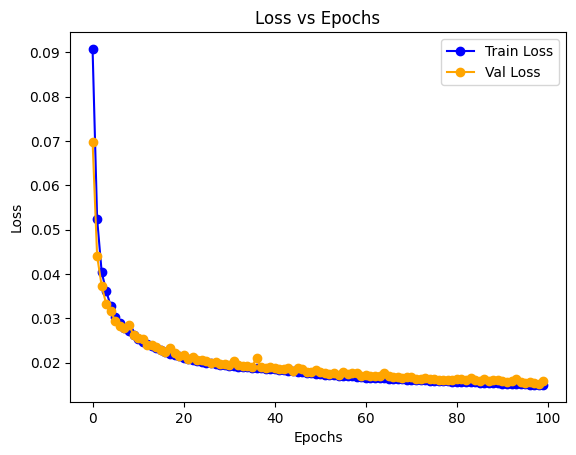

In [ ]:
model = MLP_Autoencoder(act_func='relu', lr=1, dropout=0.5, optimiser='sgd').to(device)

# Training the model
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(flattened_train_imgs, flattened_train_imgs, flattened_val_imgs, flattened_val_imgs, epochs=n_epochs)
torch.save(model.state_dict(), "/content/drive/MyDrive/smai_a4/saved_models/mlp_autoencoder/model.pth")
end_time = time.time()
print("Model Trained in time:", end_time - start_time)

plt.plot(train_loss_arr, color='blue', marker='o', label="Train Loss")
plt.plot(val_loss_arr, color='orange', marker='o', label="Val Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()
plt.close()

## Visualising reconstructed output

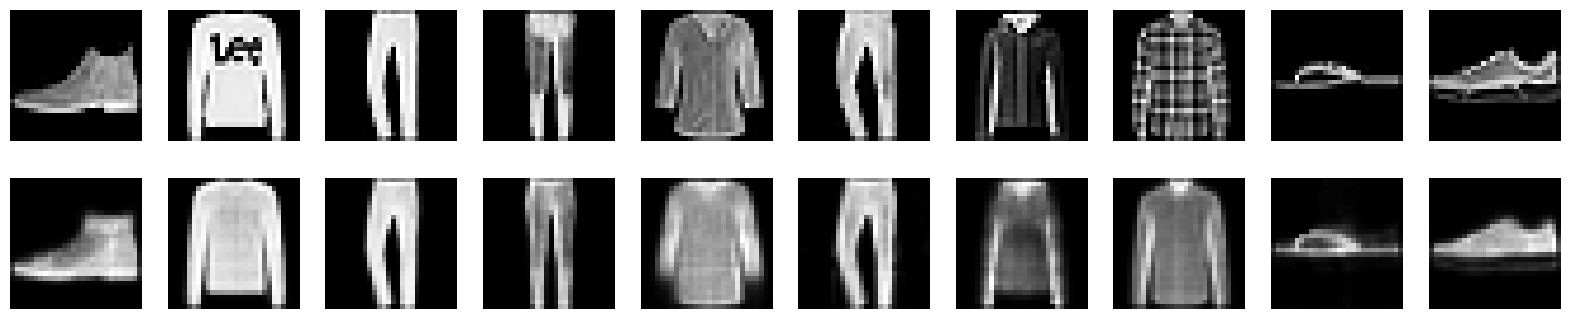

In [ ]:
plotting_imgs = flattened_test_imgs[:10]
model.eval()
with torch.no_grad():
    reconstructed_imgs = model.forward(torch.from_numpy(plotting_imgs).float().to(device))

fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    ax[0][i].imshow(plotting_imgs[i].reshape(28, 28), cmap="gray")
    ax[0][i].axis('off')
    ax[1][i].imshow(reconstructed_imgs[i].detach().cpu().numpy().reshape(28, 28), cmap="gray")
    ax[1][i].axis('off')
plt.show()
# plt.savefig("/content/drive/MyDrive/smai_a4/figures/mlp_autoencoder/org_v_recon_img.png")
plt.close()

> We can see that MLP Autoencoder performs better at reconstructing the images than CNN autoencoder as it has less reconstruction loss as well.